In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

In [2]:
accessmod56_datadir = "/home/yann/Bluesquare/AccessMod/AccessMod5usermanual - ver5.6.0 ENGLISH - and data/DATA"
accessmodng_datadir = "/home/yann/Bluesquare/accessmod-pipelines/notebooks/accessibility_v2/output_am2"

Outputs have been generated using the sample data made available at [accessmod.org](https://owncloud.unepgrid.ch/index.php/s/DSWRvM7fic65NVf) using the procedure that is part of the tutorial in the [user guide](https://doc-accessmod.unepgrid.ch/display/EN/).

* `accessmod56` refer to outputs generated with the AccessMod 5.6 (desktop) version
* `accessmod_ng` refer to outputs generated with the data pipelines used by the web application

## Land cover merge

We compare the "land cover merge" generated by the two processing chains. They are both using the same set of layer & class priorities.

In [3]:
fp = os.path.join(accessmodng_datadir, "stack.tif")
with rasterio.open(fp) as src:
    stack_ng = src.read(1, masked=True)

fp = os.path.join(
    accessmod56_datadir, "rLandCoverMerged__combi", "rLandCoverMerged__combi.img"
)
with rasterio.open(fp) as src:
    stack_56 = src.read(1, masked=True)

In [7]:
for class_value in np.unique(stack_ng):
    print(f"{class_value}: {np.count_nonzero(stack_ng == class_value)}")

1: 535
2: 4601
3: 15369
1001: 341
1002: 328
1003: 619
2000: 1623
3000: 332
--: 20744


In [8]:
for class_value in np.unique(stack_56):
    print(f"{class_value}: {np.count_nonzero(stack_56 == class_value)}")

1: 534
2: 4602
3: 15368
1001: 342
1002: 328
1003: 619
--: 22699


In [13]:
stack_ng_ = stack_ng.copy()
stack_ng_.mask[stack_ng_ >= 2000] = True
np.count_nonzero(stack_ng_ != stack_56)

6

* Priorities between layers and classes are the same in both processing chains
* In both versions, polygon features are rasterized using `all_touched=False` and linear features using `all_touched=True`
* In AccessMod web, the `2000` and `3000` classes refer to water and barrier classes. In AccessMod 5.6, they are classified as `nodata`
* In total, 6 pixels have different classes in the land cover merge. Due to different software and libraries ? (GRASS vs. GDAL/Rasterio/numpy)

## Travel times

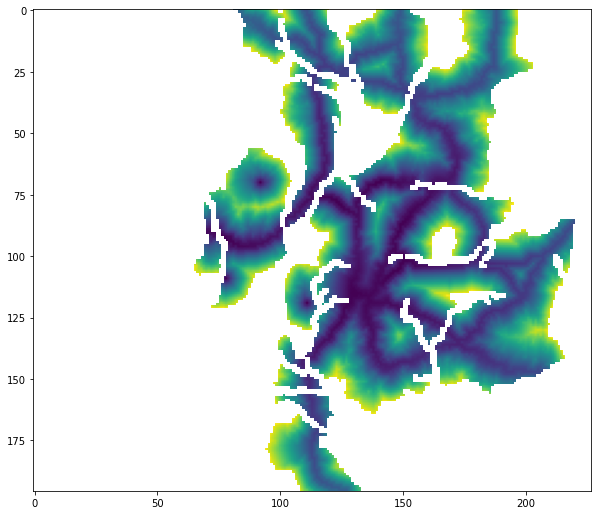

In [219]:
fp = os.path.join(
    accessmod56_datadir,
    "raster_travel_time_accessibility_360",
    "raster_travel_time_accessibility_360.img",
)
with rasterio.open(fp) as src:
    travel_times_56 = src.read(1, masked=True)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(travel_times_56, cmap="viridis", vmin=0, vmax=360);

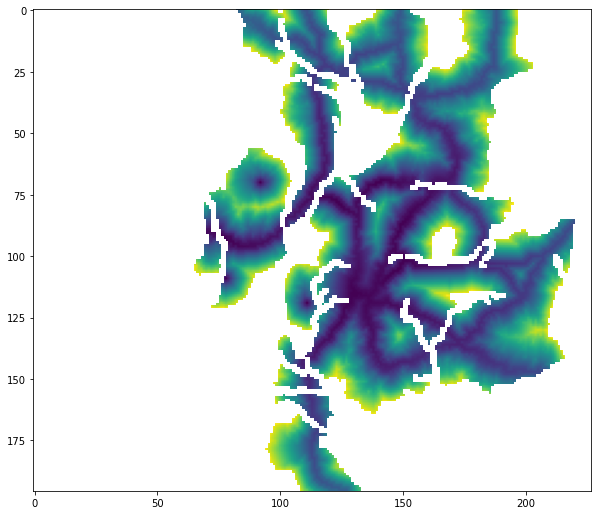

In [220]:
fp = os.path.join(accessmodng_datadir, "cumulative_cost.tif")
with rasterio.open(fp) as src:
    travel_times_ng = src.read(1, masked=True)
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(travel_times_ng, cmap="viridis", vmin=0, vmax=360);

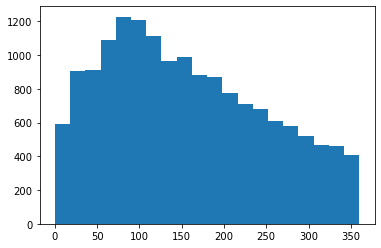

In [221]:
plt.hist(travel_times_56.ravel(), bins=20);

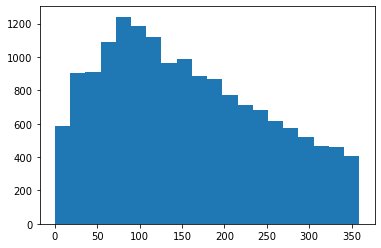

In [222]:
plt.hist(travel_times_ng.ravel(), bins=20);

In [223]:
mask = ~np.isnan(travel_times_56) & ~np.isnan(travel_times_ng)
np.mean(np.abs(travel_times_ng[mask] - travel_times_56[mask]).ravel().data)

0.6616919895711588

In [224]:
mask = ~np.isnan(travel_times_56)
np.median(np.abs(travel_times_ng[mask] - travel_times_56[mask]).ravel().data)

1.0

* Computed travel times are similar
* In average, 0.66 minutes of difference between both rasters

## Zonal statistics

We compare the accessibility metrics computed as part of the Zonal Statistics module for 4 different time thresholds: 60mn, 90mn, 120mn, 180mn. Both tests use the same vector features for zones but different travel times rasters (i.e. the ones generated previously).

In [14]:
stats_56 = pd.read_csv(os.path.join(accessmod56_datadir, "zonal_stats", "accessibility360.csv"), index_col="admin_code")
stats_ng = pd.read_csv(os.path.join(accessmodng_datadir, "zonal_stats", "zonal_stats.csv"), index_col="admin_code")

In [15]:
stats_56.sort_values(by="admin_code", inplace=True)
stats_56.round(2)

,admin_name,popTotal,PopTravelTime_60,PopTravelTime_90,PopTravelTime_120,PopTravelTime_180,PopCoveredPercent_60,PopCoveredPercent_90,PopCoveredPercent_120,PopCoveredPercent_180
admin_code,,,,,,,,,,
1,North East,1325294.54,199752.43,377406.97,545642.87,753216.15,15.07,28.48,41.17,56.83
2,North West,33635.12,0.00,0.00,0.00,75.48,0.00,0.00,0.00,0.22
3,South West,1634957.72,893086.91,1009877.57,1125539.09,1276226.02,54.62,61.77,68.84,78.06
4,South East,1146542.04,200156.83,360735.52,472017.43,651899.16,17.46,31.46,41.17,56.86


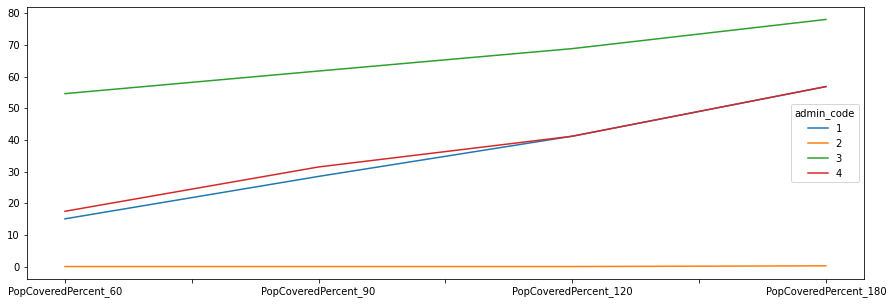

In [258]:
cols = [c for c in stats_56.columns if "PopCoveredPercent" in c]
ax = stats_56[cols].T.plot(figsize=(15, 5))

In [239]:
stats_ng = pd.read_csv(os.path.join(accessmodng_datadir, "zonal_stats", "zonal_stats.csv"), index_col="admin_code")
stats_ng.sort_values(by="admin_code", inplace=True)

# ratio to percent
for col in stats_ng.columns:
    if "Ratio" in col:
        col_new = col.replace("Ratio", "Percent").replace("mn", "")
        stats_ng[col_new] = stats_ng[col] * 100
        stats_ng.drop(columns=[col], inplace=True)

# remove "mn" suffix
for col in stats_ng.columns:
    if col.endswith("mn"):
        col_new = col.replace("mn", "")
        stats_ng.rename(columns={col: col_new}, inplace=True)

stats_ng.rename(columns={"PopTotal": "popTotal"}, inplace=True)
        
# useless columns
stats_ng.drop(columns=[c for c in stats_ng.columns if c not in stats_56.columns], inplace=True)
stats_ng.round(2)

,admin_name,popTotal,PopTravelTime_60,PopTravelTime_90,PopTravelTime_120,PopTravelTime_180,PopCoveredPercent_60,PopCoveredPercent_90,PopCoveredPercent_120,PopCoveredPercent_180
admin_code,,,,,,,,,,
1,North East,1325294.62,201638.08,385980.06,550055.06,757464.19,15.21,29.12,41.50,57.15
2,North West,33635.12,0.00,0.00,0.00,75.48,0.00,0.00,0.00,0.22
3,South West,1634957.75,897370.50,1014241.62,1128803.50,1280092.38,54.89,62.03,69.04,78.30
4,South East,1146542.00,211167.45,367994.00,476003.22,654599.75,18.42,32.10,41.52,57.09


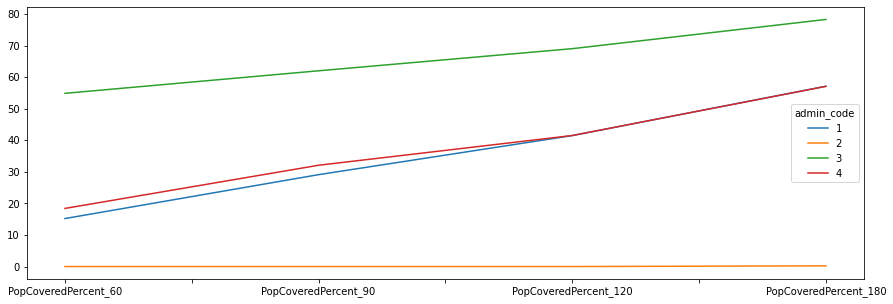

In [256]:
cols = [c for c in stats_ng.columns if "PopCoveredPercent" in c]
ax = stats_ng[cols].T.plot(figsize=(15, 5))

* Very small differences overall
* Differences in land cover merge and travel times propagates to the computed zonal statistics
* Between 0 and 1 percentage point of difference

### Total population

In [259]:
(stats_56["popTotal"] - stats_ng["popTotal"]).round(1)

admin_code
1   -0.1
2    0.0
3   -0.0
4    0.0
Name: popTotal, dtype: float64

### Population count < 60 minutes

In [260]:
(stats_56["PopTravelTime_60"] - stats_ng["PopTravelTime_60"]).round(2)

admin_code
1    -1885.65
2        0.00
3    -4283.59
4   -11010.62
Name: PopTravelTime_60, dtype: float64

### Population coverage (in percents) < 60 minutes

In [261]:
(stats_56["PopCoveredPercent_60"] - stats_ng["PopCoveredPercent_60"]).round(2)

admin_code
1   -0.14
2    0.00
3   -0.27
4   -0.96
Name: PopCoveredPercent_60, dtype: float64

### Population count < 180 minutes

In [262]:
(stats_56["PopTravelTime_180"] - stats_ng["PopTravelTime_180"]).round(2)

admin_code
1   -4248.03
2      -0.00
3   -3866.36
4   -2700.59
Name: PopTravelTime_180, dtype: float64

### Population coverage (in percents) < 180 minutes

In [263]:
(stats_56["PopCoveredPercent_180"] - stats_ng["PopCoveredPercent_180"]).round(2)

admin_code
1   -0.32
2    0.00
3   -0.24
4   -0.23
Name: PopCoveredPercent_180, dtype: float64

## Multi-modal modeling in AccessMod 5.6

In [264]:
stats_multi = pd.read_csv(os.path.join(accessmod56_datadir, "zonal_stats", "accessibility360_anisotropic.csv"), index_col="admin_code")

In [265]:
stats_multi

,admin_name,popTotal,PopTravelTime_60,PopTravelTime_90,PopTravelTime_120,PopTravelTime_180,PopCoveredPercent_60,PopCoveredPercent_90,PopCoveredPercent_120,PopCoveredPercent_180
admin_code,,,,,,,,,,
1,North East,1.325295e+06,198757.112507,3.758662e+05,5.423532e+05,7.438828e+05,14.997203,28.360960,40.923217,56.129624
2,North West,3.363512e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,South West,1.634958e+06,885825.381735,1.002549e+06,1.116434e+06,1.268399e+06,54.180324,61.319539,68.285176,77.579913
4,South East,1.146542e+06,199799.085321,3.591580e+05,4.689842e+05,6.432224e+05,17.426233,31.325320,40.904233,56.101071


In [266]:
cols = [c for c in stats_multi.columns if "popcovered" in c.lower()]

stats_multi[cols] - stats_ng[cols]

,PopCoveredPercent_60,PopCoveredPercent_90,PopCoveredPercent_120,PopCoveredPercent_180
admin_code,,,,
1,-0.212797,-0.759040,-0.576783,-1.020376
2,0.000000,0.000000,0.000000,-0.220000
3,-0.709676,-0.710461,-0.754824,-0.720087
4,-0.993767,-0.774680,-0.615767,-0.988929
